# Semi Direct Effects: Having a Closer Look on Profiles Again

This is a modified clone of [07-Semi-Direct-Effects_Compare-Domain-Averages-based-on-Aggregate-File.ipynb](07-Semi-Direct-Effects_Compare-Domain-Averages-based-on-Aggregate-File.ipynb)

## Data Description

The data aggregates have been collected and resampled in [06-Semi-Direct-Effects_Save_Domave_Aggregates.ipynb](06-Semi-Direct-Effects_Save_Domave_Aggregates.ipynb)

## Libs

In [1]:
%matplotlib inline

import os, sys
import pylab as plt
import numpy as np
import numpy

import seaborn as sns
sns.set_context('talk')


import xarray as xr
xr.set_options(keep_attrs=True)

import nawdex_analysis.io.tools


## Data Input

In [2]:
try:
    dset.close()
except:
    pass

In [3]:
fdir = '%s/icon-lem/aggregates' % (os.environ['LOCAL_DATA_PATH'],  )
fname = '%s/domain_average_resampled5min.nc' % fdir
dset = xr.open_dataset( fname ).isel( time = slice(1, 288))
    

### Set Time Range

In [4]:
t_start = '2013-05-02T08'
t_end = '2013-05-02T14'

dset = dset.sel( time = slice( t_start, t_end))

## Liquid Layer

In [5]:
qc_prof = dset['clw'].sel(mode = 'scattering').mean(['time', 'dom'])
qc_mask = qc_prof > qc_prof.max() / 2.

## Plots

In [6]:
def plot_profile(vname, time='mean', method='diff', ax=None, scale=1., plot_liquid_layer=True):

    if ax is None:
        fig = plt.figure(figsize=(5, 6))
        plt.subplots_adjust(bottom=0.2, right=0.7, left=0.3, top=0.85)
    else:
        plt.sca(ax)
    if time == 'mean':
        v = dset[vname].sel(time=slice('2013-05-02T06', '2013-05-02T18'))

    else:
        v = dset[vname].sel(time=time)

    v = v.mean('time')

    height = dset.sel(mode='scattering', dom='DOM01')[
        'pres'].mean('time') / 1e2

    if method == 'diff':
        diff = v.sel(mode='absorbing') - v.sel(mode='scattering')

        for dom in diff.dom:
            d = scale * diff.sel(dom=dom)
            plt.plot(d, height, lw=3)

        plt.axvline(0, color='gray', alpha=0.3, lw=5)

    elif method == 'ref':
        d = v.sel(mode='scattering').mean('dom')

        plt.plot(d, height, c='k', lw=3)

    # plt.title('%s / ( %s )' % (d.long_name, d.units), pad = 20)

    if plot_liquid_layer:
        h1 = height.where(qc_mask).min()
        h2 = height.where(qc_mask).max()
        
        print(h1.data, h2.data)

        plt.axhspan(h1, h2, color='darkturquoise', alpha=0.05)

    plt.ylabel('Pressure / hPa')
    plt.xlabel('%s / %s' % (d.standard_name, d.units))
    plt.ylim(1000, 200)

### Set Relevant Scales

In [7]:
c_p = 1004.
L = 2.5e6
g = 9.81
T = 8 * 3.6e3  # let's assume 8 hours interval

### Cloud Cover

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


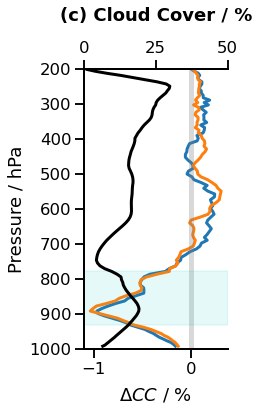

In [8]:
vname = 'clc'

plot_profile(vname)
a = plt.gca()
a.set_xlabel('$\Delta CC$ / %', labelpad=10)
#a.set_xlim(-2, 1)

a2 = plt.gca().twiny()
plot_profile(vname, ax=a2, method='ref')
a2.set_xlabel('(c) Cloud Cover / %', labelpad=20, fontweight='bold')
a2.set_xlim(0, 50)


sns.despine(top=False)
plt.savefig('../pics/prof-cc.png', dpi=300)

### Temperature

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


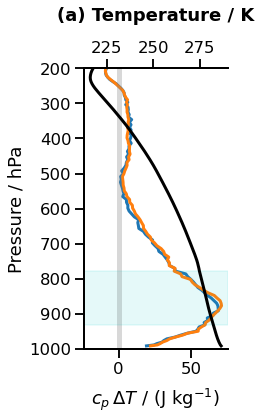

In [9]:
vname = 'ta'


plot_profile(vname, scale=c_p)
a = plt.gca()
a.set_xlabel('$c_p\,\Delta T$ / (J kg${}^{-1})$', labelpad=10)
a.set_xlim(-24, 75)

a2 = plt.gca().twiny()
plot_profile(vname, ax=a2, method='ref')
a2.set_xlabel('(a) Temperature / K', labelpad=20, fontweight='bold')


sns.despine(top=False)

plt.savefig('../pics/prof-temp.png', dpi=300)

### Humidity

In [10]:
dset['husg'] = 1e3 * dset['hus']
dset['husg'].attrs.update( dict( units = 'g kg-1') )

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


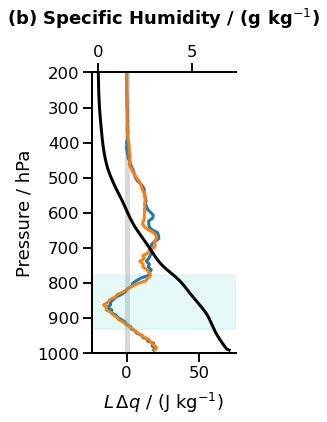

In [11]:
vname = 'husg'


plot_profile( vname, scale = L / 1e3)
a = plt.gca()
a.set_xlabel('$L\,\Delta q$ / (J kg${}^{-1})$', labelpad = 10)
a.set_xlim(-24, 75)

a2 = plt.gca( ).twiny()
plot_profile( vname, ax = a2, method = 'ref')
a2.set_xlabel('(b) Specific Humidity / (g kg${}^{-1}$)', labelpad = 20, fontweight = 'bold' )

sns.despine(top = False)
plt.savefig('../pics/prof-qv.png', dpi = 300)

### Check Relative Humidity

In [12]:
import tropy.analysis_tools.thermodynamic_variables as td

In [13]:
qv = dset['hus']
r = qv / (1 - qv)

In [14]:
dset['RH'] = td.relative_humidity( r, dset['pres'], dset['ta'])

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


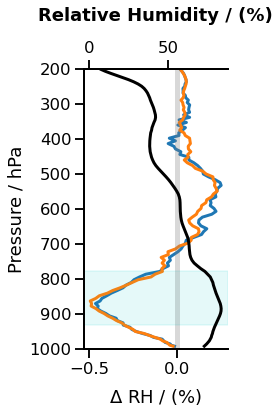

In [15]:
vname = 'RH'


plot_profile(vname, scale=1.)
a = plt.gca()
a.set_xlabel('$\Delta$ RH / (%)', labelpad=10)
#a.set_xlim(-5, 5)

a2 = plt.gca().twiny()
plot_profile(vname, ax=a2, method='ref')
a2.set_xlabel('Relative Humidity / (%)', labelpad=20, fontweight='bold')

sns.despine(top=False)

### Pressure

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


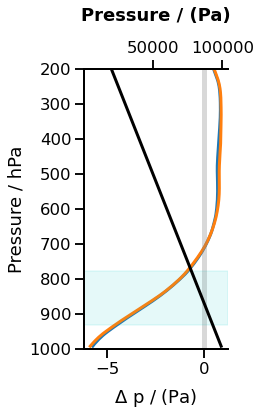

In [16]:
vname = 'pres'


plot_profile( vname, scale = 1.)
a = plt.gca()
a.set_xlabel('$\Delta$ p / (Pa)', labelpad = 10)
#a.set_xlim(-5, 5)

a2 = plt.gca( ).twiny()
plot_profile( vname, ax = a2, method = 'ref')
a2.set_xlabel('Pressure / (Pa)', labelpad = 20, fontweight = 'bold' )

sns.despine(top = False)


### Vertical Motion

In [17]:
vname  ='wa_inter'
dset[vname] = dset['wa'].interp(height_2_2 = dset.height_2)

dset[vname] = 1e2 * dset[vname]
dset[vname].attrs.update( dict( units = 'cm s-1') )


778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


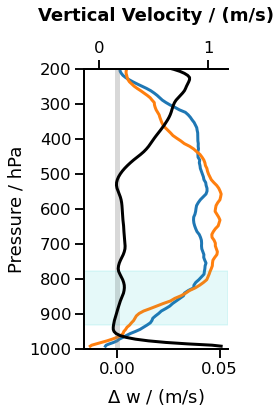

In [18]:
vname = 'wa_inter'


plot_profile( vname, scale = 1.)
a = plt.gca()
a.set_xlabel('$\Delta$ w / (m/s)', labelpad = 10)
#a.set_xlim(-5, 5)

a2 = plt.gca( ).twiny()
plot_profile( vname, ax = a2, method = 'ref')
a2.set_xlabel('Vertical Velocity / (m/s)', labelpad = 20, fontweight = 'bold' )

sns.despine(top = False)

### Liquid Water Content

In [19]:
dset['clw'] = 1e3 * dset['clw']
dset['clw'].attrs.update( dict( units = 'g kg-1') )

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


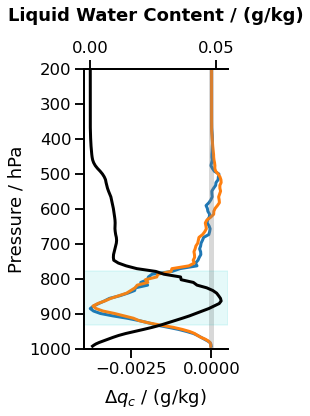

In [20]:
vname = 'clw'


plot_profile( vname, scale = 1.)
a = plt.gca()
a.set_xlabel('$\Delta q_c$ / (g/kg)', labelpad = 10)
#a.set_xlim(-5, 5)

a2 = plt.gca( ).twiny()
plot_profile( vname, ax = a2, method = 'ref')
a2.set_xlabel('Liquid Water Content / (g/kg)', labelpad = 20, fontweight = 'bold' )

sns.despine(top = False)

### Ice Water Content

778.1495972842262 931.0229864211309
778.1495972842262 931.0229864211309


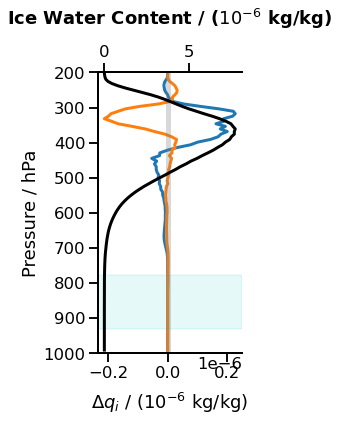

In [21]:
vname = 'cli'


plot_profile( vname, scale = 1e6 )
a = plt.gca()
a.set_xlabel('$\Delta q_i$ / ($10^{-6}$ kg/kg)', labelpad = 10)
#a.set_xlim(-5, 5)

a2 = plt.gca( ).twiny()
plot_profile( vname, ax = a2, method = 'ref', scale = 1e6)
a2.set_xlabel('Ice Water Content / ($10^{-6}$ kg/kg)', labelpad = 20, fontweight = 'bold' )

sns.despine(top = False)